In [1]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.stats import gaussian_kde
from sklearn.neural_network import MLPRegressor

from src.dataset.tools.dataloaders import get_dataloader

In [2]:
# Settings
batch_size = 50
target_scan = 1
workers = 4
method = "lstsq"  # or "lstsq"
interpolation_dim = "2"  # or "3"

project_root = Path(".").absolute().parents[1]

results_path = project_root / "results" / "linear_interpolation" 
results_path.mkdir(parents=True, exist_ok=True)

train_csv = project_root / "dataset" / "synth_crptn" / "150" / "train.csv"
train_dataloader = get_dataloader(train_csv, batch_size, workers)

tile_csv = project_root / "dataset" / "synth_crptn" / "big_tile_no_overlap" / "big_tile_dataset.csv"
tile_dataloader = get_dataloader(tile_csv, batch_size, workers, drop_last=False)

# setting idx to 0 allows for perfect interpolation -- sanity check
def interp2d(data, idx=1):
    return np.concatenate([
            griddata(
                n[idx:, :2],
                n[idx:, 3],
                n[0, :2]
            ) for n in data])

def interp3d(data, idx=1):
    return np.concatenate([
            LinearNDInterpolator(
                n[idx:, :3],
                n[idx:, 3]
           )(n[0, :3]) for n in data])

if interpolation_dim == "2":
    interp_func = interp2d
if interpolation_dim == "3":
    interp_func = interp3d

In [3]:
running_loss = 0
with torch.no_grad():
    dataset = np.empty((0, 5))
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch_idx, batch in enumerate(pbar):
        data, h_target, i_target = batch
        
        interpolation = interp_func(data, idx=1)
        
        s_scan = data[:, 1, 8]
        t_scan = data[:, 0, 8]
        
        new_batch = np.stack((
            interpolation, 
            i_target.numpy(), 
            h_target.numpy(), 
            s_scan.numpy(), 
            t_scan.numpy())).T
        
        nans = np.where(np.isnan(interpolation))
        new_batch = np.delete(new_batch, nans, axis=0)
        
        loss = np.mean(np.abs(new_batch[:, 0] - new_batch[:, 1]))
        
        running_loss += loss * batch_size
        total_loss = running_loss / (((batch_idx+1)* batch_size))
        pbar.set_postfix({
            'icurr':f"{loss:.3f}", 
            "itotl":f"{total_loss:.3f}"})
        
        dataset = np.concatenate((dataset, new_batch))
        
        if len(dataset) > 50000:
            break

  9%|▊         | 1001/11486 [00:56<09:47, 17.84it/s, icurr=0.105, itotl=0.092]


In [4]:
loss = np.mean(np.abs(dataset[:, 0] - dataset[:, 1]))
print("Interpolation Loss: ", loss)

Interpolation Loss:  0.0918034843857141


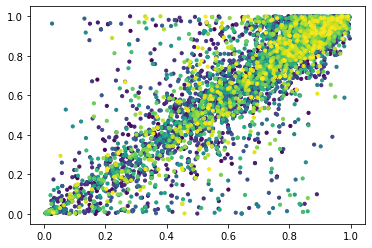

In [5]:
sample = np.random.choice(len(dataset), 5000)
ds = dataset[sample]
dsx = ds[:, 0]
dsy = ds[:, 1]
xy = np.vstack([dsy, dsx])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
dsx, dsy, z = dsx[idx], dsy[idx], z[idx]
plt.scatter(ds[:, 0], ds[:, 1], s=10, c=z)
plt.show()


[ 0. 10. 15. 20. 21. 26. 27. 30. 32. 39. 40.]
[2170, 1732, 2681, 2082, 2179, 1965, 2353, 2194, 2196, 2335, 2563]


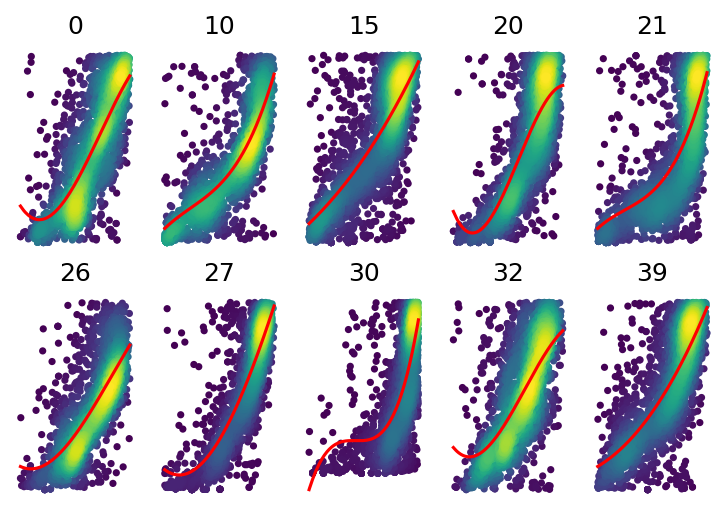

lstsq
{(0, 1): (-1.8856515453898508, 4.263412266925727, -1.8229264019910518, 0.34270066285957096), (10, 1): (0.9563426357918668, -0.6801427312334152, 0.5757531123022903, 0.07543390086763263), (15, 1): (0.05822570947186728, 0.25130942217014757, 0.5614826023740594, 0.09897138610372398), (20, 1): (-3.587124203324393, 6.817274259873356, -2.7644430839053697, 0.3740812306755432), (21, 1): (1.1856117458578477, -0.8980023093331095, 0.5523236968231886, 0.0742219223065167), (26, 1): (-0.9415679500269082, 2.4127812341634205, -0.891249239692741, 0.2019277384603188), (27, 1): (-0.5796046243687739, 2.403491434438198, -1.0353108148763102, 0.20004162889050287), (30, 1): (4.291853585123358, -5.787973421001285, 2.5899417219088385, -0.19157409160799893), (32, 1): (-1.9221484634791361, 3.9147495191789887, -1.4757180332635176, 0.34057645127056346), (39, 1): (0.05993024658871717, 0.452556273206808, 0.34200209098956197, 0.12815783694927052)}


In [8]:
# Harmonization
dataset_f = dataset[dataset[:, 4] == 1]  # filter out source-source scans
sources = np.unique(dataset_f[:, 3])  # create list of source scans
print(sources)
source_counts = []
for s in sources:
    count = len(dataset_f[dataset_f[:, 3]==s])
    source_counts.append(count)

print(source_counts)
    
transforms = {}
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(2, 5)
for i, s in enumerate(sources):
    if i == 10:
        break
    dataset_f_s = dataset_f[dataset_f[:, 3] == s]  # filter on source-target pair
    X = dataset_f_s[:, 0] # interpolated value at source for given s
    y = dataset_f_s[:, 2]                 # all gt harmonization values for S
    
    if method is "lstsq":
        xy = np.vstack([y, X])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        X, y, z = X[idx], y[idx], z[idx]
        ax.flat[i].scatter(X, y, c=z, s=6)
        A = np.vstack([X**3, X**2, X, np.ones(len(X))]).T
        v1, v2, v3, c = np.linalg.lstsq(A, y, rcond=None)[0]
        transforms[(int(s), 1)] = (v1, v2, v3, c)
        idx = X.argsort()
        X, y = X[idx], y[idx]
        ax.flat[i].plot(X, v1*(X**3)+ v2*(X**2) + v3*X + c, 'r')
        ax.flat[i].axis('off')
        ax.flat[i].set_title(f"{int(s)}")
        
        
    elif method is "MLP":
        transforms[(int(s), 1)] = MLPRegressor(
            (100, 100, 100), random_state=1, max_iter=300).fit(X, y)
        
        xy = np.vstack([y, X])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        X, y, z = X[idx], y[idx], z[idx]
        ax.flat[i].scatter(X, y, c=z, s=6)
        transforms[(int(s), 1)] = MLPRegressor((100, 100, 100)).fit(X, y)
        idx = X.argsort()
        X, y = X[idx], y[idx]
        ax.flat[i].plot(X, transforms[(int(s), 1)].predict(X), 'r')
        ax.flat[i].axis('off')
        ax.flat[i].set_title(f"{int(s)}")
    else:
        exit(f"No method: {method}")
        
plt.show()
print(method)
print(transforms)

In [9]:
running_loss = 0
import code
with torch.no_grad():
    fixed_tile = np.empty((0, 11), dtype=np.float64)
    pbar = tqdm(tile_dataloader, total=len(tile_dataloader))
    for batch_idx, batch in enumerate(pbar):
        data, h_target, i_target = batch

        tile_data = data[:, 0, :].numpy()
        
        intensity = tile_data[:, 3]
        
        source_scan = int(data[0, 0, 8])
        t = transforms[(source_scan, target_scan)]
        
        if method is "lstsq":
            fixed_intensity = (t[0]*(intensity**3)) + (t[1]*(intensity**2)) + (t[2]*intensity) + t[3]
        
#         if method is "MLP":
#             new_intensity = t.predict(intensity).reshape(-1, 1)
            
        tile_data = np.concatenate((
            tile_data[:, :3], # include gt harmonization
            h_target.numpy().reshape(-1, 1),
            tile_data[:, 3].reshape(-1, 1),
            fixed_intensity.reshape(-1, 1),
            tile_data[:, 4:]), axis=1)
        
        loss = np.mean(np.abs(tile_data[:, 5] - tile_data[:, 3]))
        
        running_loss += loss * batch_size
        total_loss = running_loss / (((batch_idx+1) * batch_size))
        pbar.set_postfix({
            "hcur": f"{float(loss):.3f}",
            "htot": f"{float(total_loss):.3f}"
        })
        
        fixed_tile = np.concatenate((fixed_tile, tile_data))
        

100%|██████████| 20000/20000 [08:45<00:00, 38.08it/s, hcur=0.107, htot=0.115]


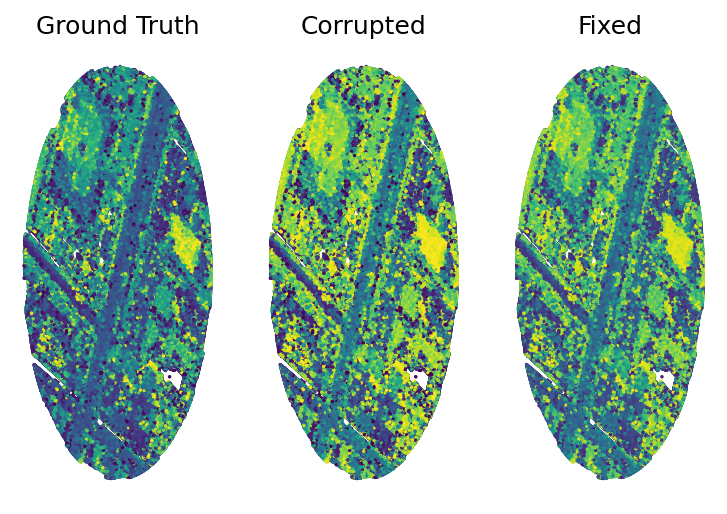

In [10]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax.flat[i].scatter(fixed_tile[:, 0], fixed_tile[:, 1], c=fixed_tile[:, 3+i], s=.5, vmin=0, vmax=1)
    ax.flat[i].axis('off')
    
ax.flat[0].set_title("Ground Truth")
ax.flat[1].set_title("Corrupted")
ax.flat[2].set_title("Fixed")
    
plt.show()
    

In [ ]:
np.savetxt(tile_csv.parents[0] / f"fixed_li_{method}.txt.gz", fixed_tile)